<a href="https://colab.research.google.com/github/PacoPacorius/MedMNIST-Image-Analysis-w-CNNs-and-Transformers---DL-assignment/blob/master/deep_learning_assignment_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator, ChestMNIST

dataset = ChestMNIST(split="val", download=True, size=28)

download = True
data_flag = 'chestmnist'

info = INFO[data_flag]['label']
dataset.montage(length=1)

DataClass = getattr(medmnist, INFO[data_flag]['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Convert 1 channel to 3 channels
    #transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) # Updated for 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Updated for 3 channels
])


# define normalized dataset
train_dataset = medmnist.ChestMNIST(split='train', download=download, transform=data_transform)
val_dataset = medmnist.ChestMNIST(split='val', download=download, transform=data_transform)
test_dataset = medmnist.ChestMNIST(split='test', download=download, transform=data_transform)

img, _ = train_dataset[0]
print(f"Shape of now 3-channel RGB image: {img.numpy().shape}")
print(f"--- Dataset: {data_flag} ---")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print("-" * 40)

print(info)

100%|██████████| 82.8M/82.8M [01:08<00:00, 1.20MB/s]


Shape of now 3-channel RGB image: (3, 28, 28)
--- Dataset: chestmnist ---
Number of training images: 78468
Number of validation images: 11219
Number of test images: 22433
----------------------------------------
{'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}


In [ ]:
import torch
import numpy as np
import random

def set_all_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}")

# Set a global seed for reproducibility
REPRODUCIBILITY_SEED = 42
set_all_seeds(REPRODUCIBILITY_SEED)


All random seeds set to 42


In [ ]:
# Create DataLoaders
batch_size = 64


train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch_size={batch_size}")
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

DataLoaders created with batch_size=64
Train DataLoader: 1227 batches
Validation DataLoader: 176 batches
Test DataLoader: 351 batches


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# define training, validation and test functions
def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float() # Labels must be float for BCEWithLogitsLoss

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # For multi-label accuracy calculation
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.numel()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    return epoch_loss, epoch_accuracy

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.numel()

    avg_loss = running_loss / len(data_loader.dataset)
    avg_accuracy = correct_predictions / total_predictions
    return avg_loss, avg_accuracy

def test_model(model, data_loader, device, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predicted_labels.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)

    # Calculate overall accuracy (mean accuracy across all labels and samples)
    overall_accuracy = (all_predictions == all_labels).mean()

    # Calculate per-class confusion matrices
    num_classes = all_labels.shape[1]
    per_class_cms = []
    for i in range(num_classes):
        cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        per_class_cms.append(cm)

    return overall_accuracy, per_class_cms

print("Training, evaluation, and testing functions defined successfully.")

Using device: cpu
Training, evaluation, and testing functions defined successfully.


In [ ]:
import torchvision
import torch.nn as nn

# 1. Load the pre-trained MobileNetV2 model
model = torchvision.models.mobilenet_v2(pretrained=True)
print("MobileNetV2 model loaded successfully.")

# 2. Freeze feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False
print("Feature extraction layers of MobileNetV2 frozen.")

# 3. Identify the input features of the original classifier's last layer
in_features = model.classifier[-1].in_features
print(f"Input features for the classifier's last layer: {in_features}")

# 4. Replace the original classifier head
# The original classifier is nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features, num_classes))
# We need to keep the Dropout layer and replace the final Linear layer with a new Linera layer with 14 output features
model.classifier = nn.Sequential(
    model.classifier[0], # Keep the Dropout layer
    nn.Linear(in_features, len(info)) # New Linear layer with 14 output features
)
print(f"Classifier head replaced with a new Linear layer for {len(info)} classes.")

# 5. Move the modified model to the appropriate device
model.to(device)
print(f"Model moved to {device}.")

print("Modified MobileNetV2 model architecture:")
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13.6M/13.6M [00:00<00:00, 38.6MB/s]


MobileNetV2 model loaded successfully.
Feature extraction layers of MobileNetV2 frozen.
Input features for the classifier's last layer: 1280
Classifier head replaced with a new Linear layer for 14 classes.
Model moved to cpu.
Modified MobileNetV2 model architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, 

In [ ]:
import torch.optim as optim

# 1. Initialize the Adam optimizer, optimizing only the classifier's parameters
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
print("Optimizer (Adam) initialized, optimizing only classifier parameters.")

# 2. Define the loss function
criterion = nn.BCEWithLogitsLoss()
print("Loss function (BCEWithLogitsLoss) defined.")

# 3. Create empty lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 20

print(f"\nStarting training for {epochs} epochs...")
for epoch in range(epochs):
    # a. Call the train_one_epoch function
    epoch_loss, epoch_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # b. Call the evaluate_model function for validation
    avg_loss, avg_accuracy = evaluate_model(model, val_loader, criterion, device)

    # c. Append the metrics to their respective lists
    train_losses.append(epoch_loss)
    val_losses.append(avg_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(avg_accuracy)

    # d. Print the current epoch number and metrics
    print(f"Epoch {epoch+1}/{epochs}:\n" \
          f"  Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}\n" \
          f"  Val Loss:   {avg_loss:.4f}, Val Accuracy:   {avg_accuracy:.4f}")

print("\nFeature extraction training complete.")

Optimizer (Adam) initialized, optimizing only classifier parameters.
Loss function (BCEWithLogitsLoss) defined.

Starting training for 20 epochs...
Epoch 1/20:
  Train Loss: 0.1967, Train Accuracy: 0.9476
  Val Loss:   0.1887, Val Accuracy:   0.9492
Epoch 2/20:
  Train Loss: 0.1905, Train Accuracy: 0.9479
  Val Loss:   0.1868, Val Accuracy:   0.9491
Epoch 3/20:
  Train Loss: 0.1896, Train Accuracy: 0.9479
  Val Loss:   0.1851, Val Accuracy:   0.9490
Epoch 4/20:
  Train Loss: 0.1883, Train Accuracy: 0.9478
  Val Loss:   0.1830, Val Accuracy:   0.9492
Epoch 5/20:
  Train Loss: 0.1880, Train Accuracy: 0.9480
  Val Loss:   0.1832, Val Accuracy:   0.9492
Epoch 6/20:
  Train Loss: 0.1874, Train Accuracy: 0.9480
  Val Loss:   0.1848, Val Accuracy:   0.9490
Epoch 7/20:
  Train Loss: 0.1869, Train Accuracy: 0.9479
  Val Loss:   0.1810, Val Accuracy:   0.9491
Epoch 8/20:
  Train Loss: 0.1866, Train Accuracy: 0.9480
  Val Loss:   0.1867, Val Accuracy:   0.9491
Epoch 9/20:
  Train Loss: 0.1865, Tr

In [ ]:
print("\n--- Fine-tuning Setup ---")

# 1. Unfreeze the last two convolutional blocks of the MobileNetV2 model
# The structure of MobileNetV2 features typically ends with a block at index 18.
# To unfreeze the 'last two convolutional blocks', we often refer to the last few layers
# of the 'features' part. MobileNetV2's features are a Sequential module.
# Checking the model.features structure, index 17 and 18 are usually the last two blocks.
for param in model.features[17].parameters():
    param.requires_grad = True
for param in model.features[18].parameters():
    param.requires_grad = True
print("Last two convolutional blocks (features[17] and features[18]) unfrozen.")

# 2. Ensure that the parameters of the classifier head also have requires_grad=True
# This was already set when we replaced the classifier, but we explicitly confirm.
for param in model.classifier.parameters():
    param.requires_grad = True
print("Classifier head parameters confirmed to be trainable.")

# Verify which layers are now trainable
print("\nVerifying trainable layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: Trainable")

# 3. Create new DataLoaders with a batch_size of 32 for fine-tuning
fine_tune_batch_size = 32

fine_tune_train_loader = data.DataLoader(dataset=train_dataset, batch_size=fine_tune_batch_size, shuffle=True)
fine_tune_val_loader = data.DataLoader(dataset=val_dataset, batch_size=fine_tune_batch_size, shuffle=False)
fine_tune_test_loader = data.DataLoader(dataset=test_dataset, batch_size=fine_tune_batch_size, shuffle=False)

print(f"\nNew DataLoaders created with batch_size={fine_tune_batch_size}.")

# 4. Print the lengths of the new DataLoaders
print(f"Train DataLoader (fine-tuning): {len(fine_tune_train_loader)} batches")
print(f"Validation DataLoader (fine-tuning): {len(fine_tune_val_loader)} batches")
print(f"Test DataLoader (fine-tuning): {len(fine_tune_test_loader)} batches")


--- Fine-tuning Setup ---
Last two convolutional blocks (features[17] and features[18]) unfrozen.
Classifier head parameters confirmed to be trainable.

Verifying trainable layers:
  features.17.conv.0.0.weight: Trainable
  features.17.conv.0.1.weight: Trainable
  features.17.conv.0.1.bias: Trainable
  features.17.conv.1.0.weight: Trainable
  features.17.conv.1.1.weight: Trainable
  features.17.conv.1.1.bias: Trainable
  features.17.conv.2.weight: Trainable
  features.17.conv.3.weight: Trainable
  features.17.conv.3.bias: Trainable
  features.18.0.weight: Trainable
  features.18.1.weight: Trainable
  features.18.1.bias: Trainable
  classifier.1.weight: Trainable
  classifier.1.bias: Trainable

New DataLoaders created with batch_size=32.
Train DataLoader (fine-tuning): 2453 batches
Validation DataLoader (fine-tuning): 351 batches
Test DataLoader (fine-tuning): 702 batches


In [ ]:
print("\nStarting fine-tuning training...")

# 1. Initialize a new Adam optimizer for fine-tuning
# This optimizer should include parameters from the unfrozen last two convolutional blocks
# (model.features[17], model.features[18]) as well as the classifier head (model.classifier).
# Parameters that have requires_grad=True will be included automatically.
fine_tune_optimizer = optim.Adam(model.parameters(), lr=1e-4)
print("Fine-tuning optimizer (Adam) initialized with learning rate 1e-4.")

# 2. The loss function (criterion) is already defined from the previous step.
# criterion = nn.BCEWithLogitsLoss()

# 3. Set the number of fine-tuning epochs
fine_tune_epochs = 15

for epoch in range(fine_tune_epochs):
    # a. Call the train_one_epoch function
    epoch_loss, epoch_accuracy = train_one_epoch(model, fine_tune_train_loader, fine_tune_optimizer, criterion, device)

    # b. Call the evaluate_model function for validation
    avg_loss, avg_accuracy = evaluate_model(model, fine_tune_val_loader, criterion, device)

    # c. Append the metrics to their respective lists
    train_losses.append(epoch_loss)
    val_losses.append(avg_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(avg_accuracy)

    # d. Print the current fine-tuning epoch number and metrics
    print(f"Fine-tune Epoch {epoch+1}/{fine_tune_epochs}:\n" \
          f"  Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}\n" \
          f"  Val Loss:   {avg_loss:.4f}, Val Accuracy:   {avg_accuracy:.4f}")

print("\nFine-tuning training complete.")


Starting fine-tuning training...
Fine-tuning optimizer (Adam) initialized with learning rate 1e-4.
Fine-tune Epoch 1/15:
  Train Loss: 0.1798, Train Accuracy: 0.9485
  Val Loss:   0.1743, Val Accuracy:   0.9492
Fine-tune Epoch 2/15:
  Train Loss: 0.1763, Train Accuracy: 0.9486
  Val Loss:   0.1742, Val Accuracy:   0.9492
Fine-tune Epoch 3/15:
  Train Loss: 0.1752, Train Accuracy: 0.9486
  Val Loss:   0.1742, Val Accuracy:   0.9492
Fine-tune Epoch 4/15:
  Train Loss: 0.1746, Train Accuracy: 0.9486
  Val Loss:   0.1727, Val Accuracy:   0.9492
Fine-tune Epoch 5/15:
  Train Loss: 0.1740, Train Accuracy: 0.9486
  Val Loss:   0.1726, Val Accuracy:   0.9492
Fine-tune Epoch 6/15:
  Train Loss: 0.1733, Train Accuracy: 0.9486
  Val Loss:   0.1734, Val Accuracy:   0.9492
Fine-tune Epoch 7/15:
  Train Loss: 0.1730, Train Accuracy: 0.9486
  Val Loss:   0.1731, Val Accuracy:   0.9492
Fine-tune Epoch 8/15:
  Train Loss: 0.1726, Train Accuracy: 0.9486
  Val Loss:   0.1732, Val Accuracy:   0.9492
Fine

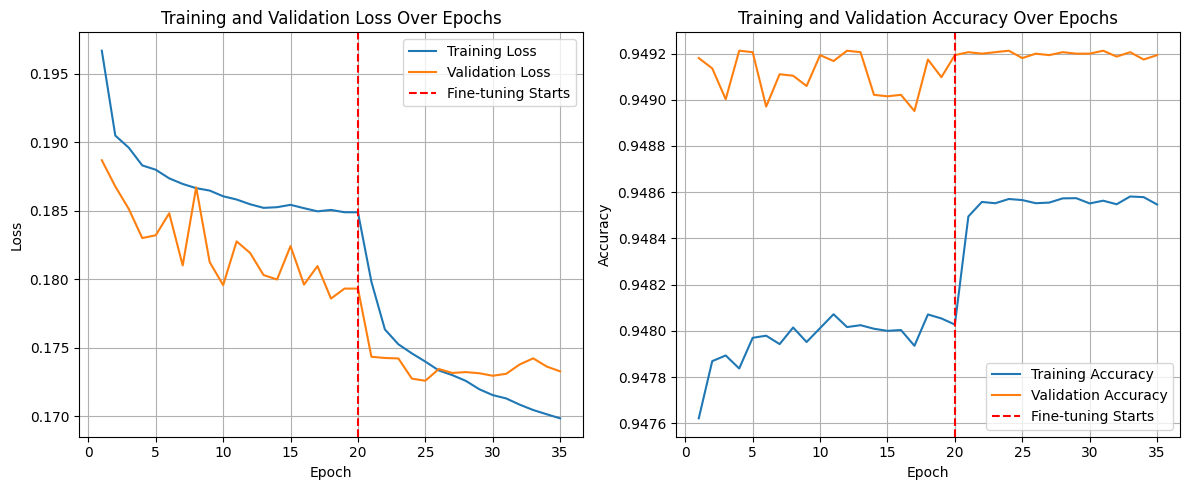

Plots of training and validation metrics generated successfully.


In [ ]:
import matplotlib.pyplot as plt

# Combine epochs for plotting
total_epochs = len(train_losses)
epochs_range = range(1, total_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.axvline(x=20, color='r', linestyle='--', label='Fine-tuning Starts') # Mark where fine-tuning began
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.axvline(x=20, color='r', linestyle='--', label='Fine-tuning Starts') # Mark where fine-tuning began
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Plots of training and validation metrics generated successfully.")

In [ ]:
print("\n--- Evaluating Model on Test Set ---")

# Get class names from the 'info' dictionary
class_names = list(info.values())

# Call the test_model function
overall_accuracy, per_class_cms = test_model(model, fine_tune_test_loader, device, class_names)

print(f"\nOverall Test Accuracy: {overall_accuracy:.4f}")

print("\nPer-Class Confusion Matrices:")
for i, cm in enumerate(per_class_cms):
    print(f"Class: {class_names[i]}")
    print(f"  True Negative (TN): {cm[0, 0]}")
    print(f"  False Positive (FP): {cm[0, 1]}")
    print(f"  False Negative (FN): {cm[1, 0]}")
    print(f"  True Positive (TP): {cm[1, 1]}")
    print("---------------------------------")

print("Model evaluation on test set complete.")


--- Evaluating Model on Test Set ---

Overall Test Accuracy: 0.9474

Per-Class Confusion Matrices:
Class: atelectasis
  True Negative (TN): 20013
  False Positive (FP): 0
  False Negative (FN): 2420
  True Positive (TP): 0
---------------------------------
Class: cardiomegaly
  True Negative (TN): 21851
  False Positive (FP): 0
  False Negative (FN): 582
  True Positive (TP): 0
---------------------------------
Class: effusion
  True Negative (TN): 19671
  False Positive (FP): 8
  False Negative (FN): 2745
  True Positive (TP): 9
---------------------------------
Class: infiltration
  True Negative (TN): 18495
  False Positive (FP): 0
  False Negative (FN): 3938
  True Positive (TP): 0
---------------------------------
Class: mass
  True Negative (TN): 21300
  False Positive (FP): 0
  False Negative (FN): 1133
  True Positive (TP): 0
---------------------------------
Class: nodule
  True Negative (TN): 21098
  False Positive (FP): 0
  False Negative (FN): 1335
  True Positive (TP): 0
